# Real Data Analysis

In this section, we import necessary libraries and tools to perform real data analysis. 

- **Libraries and Tools:**
  - `functions_main`: A custom utility module for specific model functions. 
  - `numpy`: For numerical computations and array manipulations.
  - `pandas`: For handling and preprocessing tabular data.
  - `os`: For interacting with the operating system to manage files and directories.
  - `sklearn.preprocessing.StandardScaler`: For standardizing features by removing the mean and scaling to unit variance.
  - `matplotlib.pyplot`: For data visualization and plotting.
  - `sklearn.model_selection.KFold`: For implementing k-fold cross-validation to evaluate model performance. 

In [1]:
from functions_main import *  
import numpy as np
import pandas as pd
import os 
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from matplotlib.lines import Line2D

## Useful functions

In [2]:
####################### 1. DP estimation of standard deviation ########################
def St_DP(Y, epsilon):

    """
    (ε,0)-DP estimator of the standard deviation based on clipping and the Laplace mechanism.

    Parameters
    ----------
    Y : n by 1 numpy array of response variables. 
    epsilon :  privacy parameter.
    """

    n =  Y.size
    gamma = np.log(n)
    y =  np.clip(np.asarray(Y, dtype=float), -gamma, gamma)
    m1 = y.mean()
    m2 = np.mean(y**2)  
    Delta1 = 2*gamma / n
    Delta2 = (gamma**2) / n

    epsilon1 = epsilon2 = epsilon /2    # Split the privacy budget equally between the mean and second moment
    b1 = Delta1 / float(epsilon1)
    b2 = Delta2 / float(epsilon2)
    noise1 =  rgt.laplace(0.0, b1)
    noise2 =  rgt.laplace(0.0, b2) 
         
    m1_dp = m1 + noise1
    m2_dp = m2 + noise2
    var_dp = float(m2_dp - m1_dp**2)
    if var_dp > 0:
        st_dp = np.sqrt(var_dp)
    else:
        st_dp = 2.0
    return st_dp

#####################  2. huber & ridge initialization #####################  
def huber_ridge_priv(X, Y, tau, epsilon, delta): 

    '''
    Huber + ridge regression & output perturbation
    
    Parameters
    ---------
    X : n by p0 numpy array of covariates; each row is an observation vector. (no intercept)
    Y : n by 1 numpy array of response variables. 
    tau : (DP) robust parameter for huber regression.
    epsilon,delta : privacy parameters.   
    '''

    n, p0 = X.shape
    gamma = np.sqrt(p0+1)/6 
    X_t = clipping_l2(X, gamma) 
 
    Z = np.hstack([np.ones((n, 1)), X_t])   # [1, X̃]
    beta = cp.Variable(p0 + 1) 

    resid = Y - Z  @ beta
    lam = 0.2 # Ridge regularization parameter
    obj = (1.0 / n) * cp.sum(cp.huber(resid, tau)) + 0.5 * lam * cp.sum_squares(  beta) 

    prob = cp.Problem(cp.Minimize(obj)) 
    prob.solve(solver="SCS", verbose=False, warm_start=True)

    b = np.asarray(beta.value).ravel() 
    B = np.sqrt(1 + gamma**2)
    noise_scale = 2*B*tau*((  ( 2 *np.log(1.25 /delta))**0.5 ))/(n*epsilon*lam)
    bDP = b + noise_scale * rgt.standard_normal(p0 + 1)
    return bDP  

###########  3. Compute the noise scale sigma_scale ################
def compute_sigma_scale(T, gamma, epsilon, delta):
    """
    Compute the noise scale sigma_scale for NoisyGD / DP gradient updates.

    Parameters
    ----------
    T :  Number of gradient descent iterations.
    gamma : L2 clipping bound.
    epsilon, delta : Privacy parameters. 
    """

    T = float(T)
    gamma = float(gamma)
    delta = float(delta)

    term1 = T * np.sqrt(2 * np.log(1.25 * T / delta))
    term2 = np.sqrt(5 * T * np.log(2 / delta) * np.log(2.5 * T / delta))
    base = 2 * gamma * (term1 if term1 < term2 else term2)
    eps_arr = np.asarray(epsilon, dtype=float)

    sigma_scale = base / eps_arr   
    if np.isscalar(epsilon):
        return float(sigma_scale)
    return sigma_scale

####################### 4. DP support recovery ########################
def dp_top_s_laplace_peeling(u , s , eps , Delta , keep_order  = True, rng=None): 
    rng = np.random.default_rng() if rng is None else rng
    p = u.shape[0]
    s = int(min(max(s, 0), p))
    if s == 0: return np.array([], dtype=int)
    eps_each = eps / s
    scale    = Delta / eps_each   # = (s * Delta) / eps
    chosen = []
    mask   = np.ones(p, dtype=bool)
    for _ in range(s):
        noise = rng.laplace(0.0, scale, size=p)
        scores = np.where(mask, u + noise, -np.inf)
        j = int(np.argmax(scores))
        chosen.append(j)
        mask[j] = False
    idx = np.array(chosen, dtype=int)
    if keep_order:
        idx.sort()                
    return idx

## Low-Dimensional Real Dataset

In this section, we analyze a low-dimensional real-world dataset: **housing price data**. This dataset contains information on housing features and their corresponding prices, making it suitable for regression analysis in a low-dimensional setting.

- **Dataset Overview**:
  - The dataset includes various features related to houses, such as median income,housing median age,total population,number of households,and the total number of rooms across all houses within a block group.
  - The target variable is the logarithm of the median house value of each block group.

- **Download Address**:
  The dataset can be downloaded from the following link: [Housing Price Data](http://lib.stat.cmu.edu/datasets/houses.zip) 


### Data Preparation

In this step, we process the housing price dataset for analysis:

1. **Data Loading**:
   - Read the dataset from the  local file.
   - The dataset used in this analysis is derived from the original **cadata.txt** file. The **cadata_new.txt** file has been preprocessed by removing the textual descriptions from the original dataset, leaving only the numerical data.   
   - Extract the predictor variables (features) and response variable (median house value).

2. **Log Transformation**:
   - Apply a logarithmic transformation to the response variable (median house value).

3. **Feature Standardization**:
   - Standardize the predictor variables.


In [3]:
### data ###
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'realdata/lowdim_house_data/cadata_new.txt')
data_org  = np.loadtxt(file_path)
data_house_org = pd.DataFrame(data_org,columns=['median_house_value','median_income','housing_median_age','total_rooms','total_bedrooms','population','households','latitude','longitude'])
data_house = data_house_org[['median_house_value','median_income','housing_median_age','population','households','total_rooms']]

Y_house = np.array(np.log(data_house['median_house_value']))
X_house = data_house.iloc[:,1:] # p=5
## standardize the data
scaler = StandardScaler()
X_house = pd.DataFrame(scaler.fit_transform(X_house),columns=X_house.columns)

###  Compare the (ε,δ)-DP Huber vs. Non-Private Huber

In this section, we compare the performance of `noisygd` with `gd`. The (ε,δ)-DP  Huber regression introduces privacy-preserving noise into the model, while the non-private Huber regression does not.

We will evaluate both models in terms of:
1. **Error comparison**: Measure the prediction errors for both models using the same dataset.
2. **Impact of privacy**: Analyze how the introduction of noise in the (ε,δ)-DP Huber regression affects the model's performance, particularly as the privacy parameter (ε) varies, in comparison to the benchmark, which is the performance of the `gd` applied to the entire dataset without any privacy constraints.


In [4]:
sequence = np.arange(5000, 20001, 5000)
Y_house_copy = np.array(Y_house.copy()).reshape(-1)
X_house_copy = np.array(X_house.copy())
n = X_house_copy.shape[0]
p = X_house_copy.shape[1]
 
#### Comparison ####

result_mse = []
result_priv1_mse = []
result_priv2_mse = []
result_priv3_mse = []

MASTER_SEED = 2025
rgt.seed(MASTER_SEED)
import random
random.seed(MASTER_SEED)

for index in range(len(sequence)):
    rgt.seed(MASTER_SEED+index+1)
    numm = sequence[index]
    print(numm)
    random_rows = np.random.choice(n, numm, replace=False)
    X_sample = X_house_copy[random_rows] 
    Y_sample = Y_house_copy[random_rows] 
 
    
    result_mse_temp = []
    result_priv1_mse_temp = []
    result_priv2_mse_temp = []
    result_priv3_mse_temp = []
    
    for rep in range(300):
        rgt.seed(MASTER_SEED+rep + 1)
        train_idx = np.random.choice(numm, size=int(0.8 * numm), replace=False)
        test_idx = np.setdiff1d(np.arange(numm), train_idx)
        
        # Split into 80% training and 20% testing 
        X_train, X_test = X_sample[train_idx], X_sample[test_idx]
        Y_train, Y_test = Y_sample[train_idx], Y_sample[test_idx]
        n_train = X_train.shape[0]
        X_test_new = np.hstack([np.ones((X_test.shape[0], 1)), X_test])  # add intercept
                
        epsilon = np.array([.3, .5, .9])
        delta = 10/(n_train**1.1)
        epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
        delta_init = delta/6 
        epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
        delta_est = 5*delta/6

        
        #---- initialization ----
        epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
        epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
        tau_init_1 =   St_DP(Y_train, epsilon = epsilon_tau[0])   
        beta_0DP_1 =  huber_ridge_priv(X_train, Y_train, tau=tau_init_1, epsilon= epsilon_ridge[0], delta= delta_init) 
        tau_init_2 =   St_DP(Y_train, epsilon = epsilon_tau[1])   
        beta_0DP_2 =  huber_ridge_priv(X_train, Y_train, tau=tau_init_2, epsilon= epsilon_ridge[1], delta= delta_init) 
        tau_init_3 =   St_DP(Y_train, epsilon = epsilon_tau[2])   
        beta_0DP_3 =  huber_ridge_priv(X_train, Y_train, tau=tau_init_3, epsilon= epsilon_ridge[2], delta= delta_init) 
        #---- estimation ---- 
        gamma = 0.5*(p + np.log(n_train))**0.5
        T = int(np.ceil(2*np.log(n_train)))
        sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est) 
        tau_priv_1 = .04* tau_init_1 * (n_train * epsilon[0]  /(p+np.log(n_train)))**0.5
        tau_priv_2 = .04* tau_init_2 * (n_train * epsilon[1]  /(p+np.log(n_train)))**0.5
        tau_priv_3 = .04* tau_init_3 * (n_train * epsilon[2]  /(p+np.log(n_train)))**0.5   
        lr  =  0.2 # learning rate  
        model = Huber(X_train, Y_train,intercept=True) 
        out_priv_1 = model.noisygd(tau=tau_priv_1, lr= lr, beta0=beta_0DP_1, B=gamma , sigma_scale=sigma_scale[0],T=T) 
        out_priv_2 = model.noisygd(tau=tau_priv_2, lr= lr, beta0=beta_0DP_2, B=gamma , sigma_scale=sigma_scale[1],T=T) 
        out_priv_3 = model.noisygd(tau=tau_priv_3, lr= lr, beta0=beta_0DP_3, B=gamma , sigma_scale=sigma_scale[2],T=T) 
        Y_priv1_pred = X_test_new @ out_priv_1['beta']
        Y_priv2_pred = X_test_new @ out_priv_2['beta']
        Y_priv3_pred = X_test_new @ out_priv_3['beta']
        mse_priv1 = np.mean((Y_test - Y_priv1_pred) ** 2)
        mse_priv2 = np.mean((Y_test - Y_priv2_pred) ** 2)
        mse_priv3 = np.mean((Y_test - Y_priv3_pred) ** 2)
        
        ############################################### 
        #----------------  Non-private  --------------- 
        ###############################################
        model = Huber(X_train, Y_train,intercept=True)
        tau0 = np.sqrt(np.mean(Y_train**2)-(np.mean(Y_train)**2))
        tau_np = .2 *tau0* (n_train/(p+np.log(n_train)))**0.5   
        out  = model.gd(tau=tau_np,  lr = 0.5, beta0= np.array([]), T=T)   
        Y_pred = X_test_new @ out['beta']
        mse_huber = np.mean((Y_test - Y_pred) ** 2) 
        
        result_mse_temp.append(mse_huber)
        result_priv1_mse_temp.append(mse_priv1)
        result_priv2_mse_temp.append(mse_priv2)
        result_priv3_mse_temp.append(mse_priv3)
    
    result_mse.append((result_mse_temp))
    result_priv1_mse.append((result_priv1_mse_temp))
    result_priv2_mse.append((result_priv2_mse_temp))
    result_priv3_mse.append((result_priv3_mse_temp))


5000
10000
15000
20000


### Plots for Low-Dimensional realdata Results

In [5]:
def plot_mse_boxplots(sequence,
                      result_mse,
                      result_priv1_mse,
                      result_priv2_mse,
                      result_priv3_mse,
                      y_label="MSPE" 
                      ):
    """
    Boxplots of test MSE across replications, grouped by sample size n.

    Parameters
    ----------
    sequence : array_like, shape (num_n,)
        Sample sizes used in the simulation, e.g. [5000, 10000, 15000, 20000].
    result_mse, result_priv1_mse, result_priv2_mse, result_priv3_mse :
        list of list, each of length len(sequence).
        For each i, result_*[i] is a list of MSEs over replications
        at sample size sequence[i].

        - result_priv1_mse: DP, epsilon = 0.3
        - result_priv2_mse: DP, epsilon = 0.5
        - result_priv3_mse: DP, epsilon = 0.9
        - result_mse      : Non-private

    y_label : str
        Label for y-axis. 
        
    """
    

    sequence = np.asarray(sequence)
    num_n = len(sequence)
    num_methods = 4

    # Method order: 0: eps=0.3, 1: eps=0.5, 2: eps=0.9, 3: non-private
    method_colors = {
        0: 'seagreen',   # DP, epsilon = 0.3
        1: 'orange',     # DP, epsilon = 0.5
        2: 'red',        # DP, epsilon = 0.9
        3: 'deepskyblue' # Non-private
    }

    method_labels = {
        0: 'epsilon = 0.3',
        1: 'epsilon = 0.5',
        2: 'epsilon = 0.9',
        3: 'Non-private'
    }
 
    all_vals = []
    for i in range(num_n):
        all_vals.extend(result_priv1_mse[i])
        all_vals.extend(result_priv2_mse[i])
        all_vals.extend(result_priv3_mse[i])
        all_vals.extend(result_mse[i])
    all_vals = np.asarray(all_vals)

 
    group_width = num_methods + 1.0    
    group_centers = np.arange(num_n) * group_width

    box_data = []
    box_positions = []

    for k in range(num_n):  # loop over n
        method_lists = [
            result_priv1_mse[k],  # 0: eps=0.3
            result_priv2_mse[k],  # 1: eps=0.5
            result_priv3_mse[k],  # 2: eps=0.9
            result_mse[k]         # 3: non-private
        ]

        for m_idx in range(num_methods):
            vals = np.asarray(method_lists[m_idx])

            
            box_data.append(vals)
            pos = group_centers[k] + m_idx
            box_positions.append(pos)
 
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)

    bp = ax.boxplot(
        box_data,
        positions=box_positions,
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )
 
    for i, patch in enumerate(bp['boxes']):
        m_idx = i % num_methods
        patch.set_facecolor(method_colors[m_idx])
        patch.set_edgecolor('black')
        patch.set_alpha(0.8)
 
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1.2)
 
    ax.set_xticks(group_centers + (num_methods - 1) / 2.0)
    xtick_labels = [rf'$m={int(v)}$' for v in sequence]
    ax.set_xticklabels(xtick_labels, fontsize=11)
    ax.set_xlabel('Sample size', fontsize=12, fontweight='bold')

    
    for k in range(num_n - 1):
        last_k = group_centers[k] + (num_methods - 1)
        first_k1 = group_centers[k+1]
        x_sep = 0.5 * (last_k + first_k1)
        ax.axvline(
            x=x_sep,
            color='grey',
            linestyle='--',
            linewidth=1,
            alpha=0.6,
            zorder=0
        )

 
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')

 
    ax.set_facecolor('white')
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Legend: 4 methods
    legend_handles = [
        Line2D([0], [0], color=method_colors[i], lw=4)
        for i in range(num_methods)
    ]
    legend_labels = [method_labels[i] for i in range(num_methods)]

    legend = fig.legend(
        legend_handles,
        legend_labels,
        loc='center left',
        bbox_to_anchor=(0.93, 0.5),
        frameon=True,
        prop={'size': 11}
    )
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(1)
    frame.set_facecolor('white')

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    return fig, ax


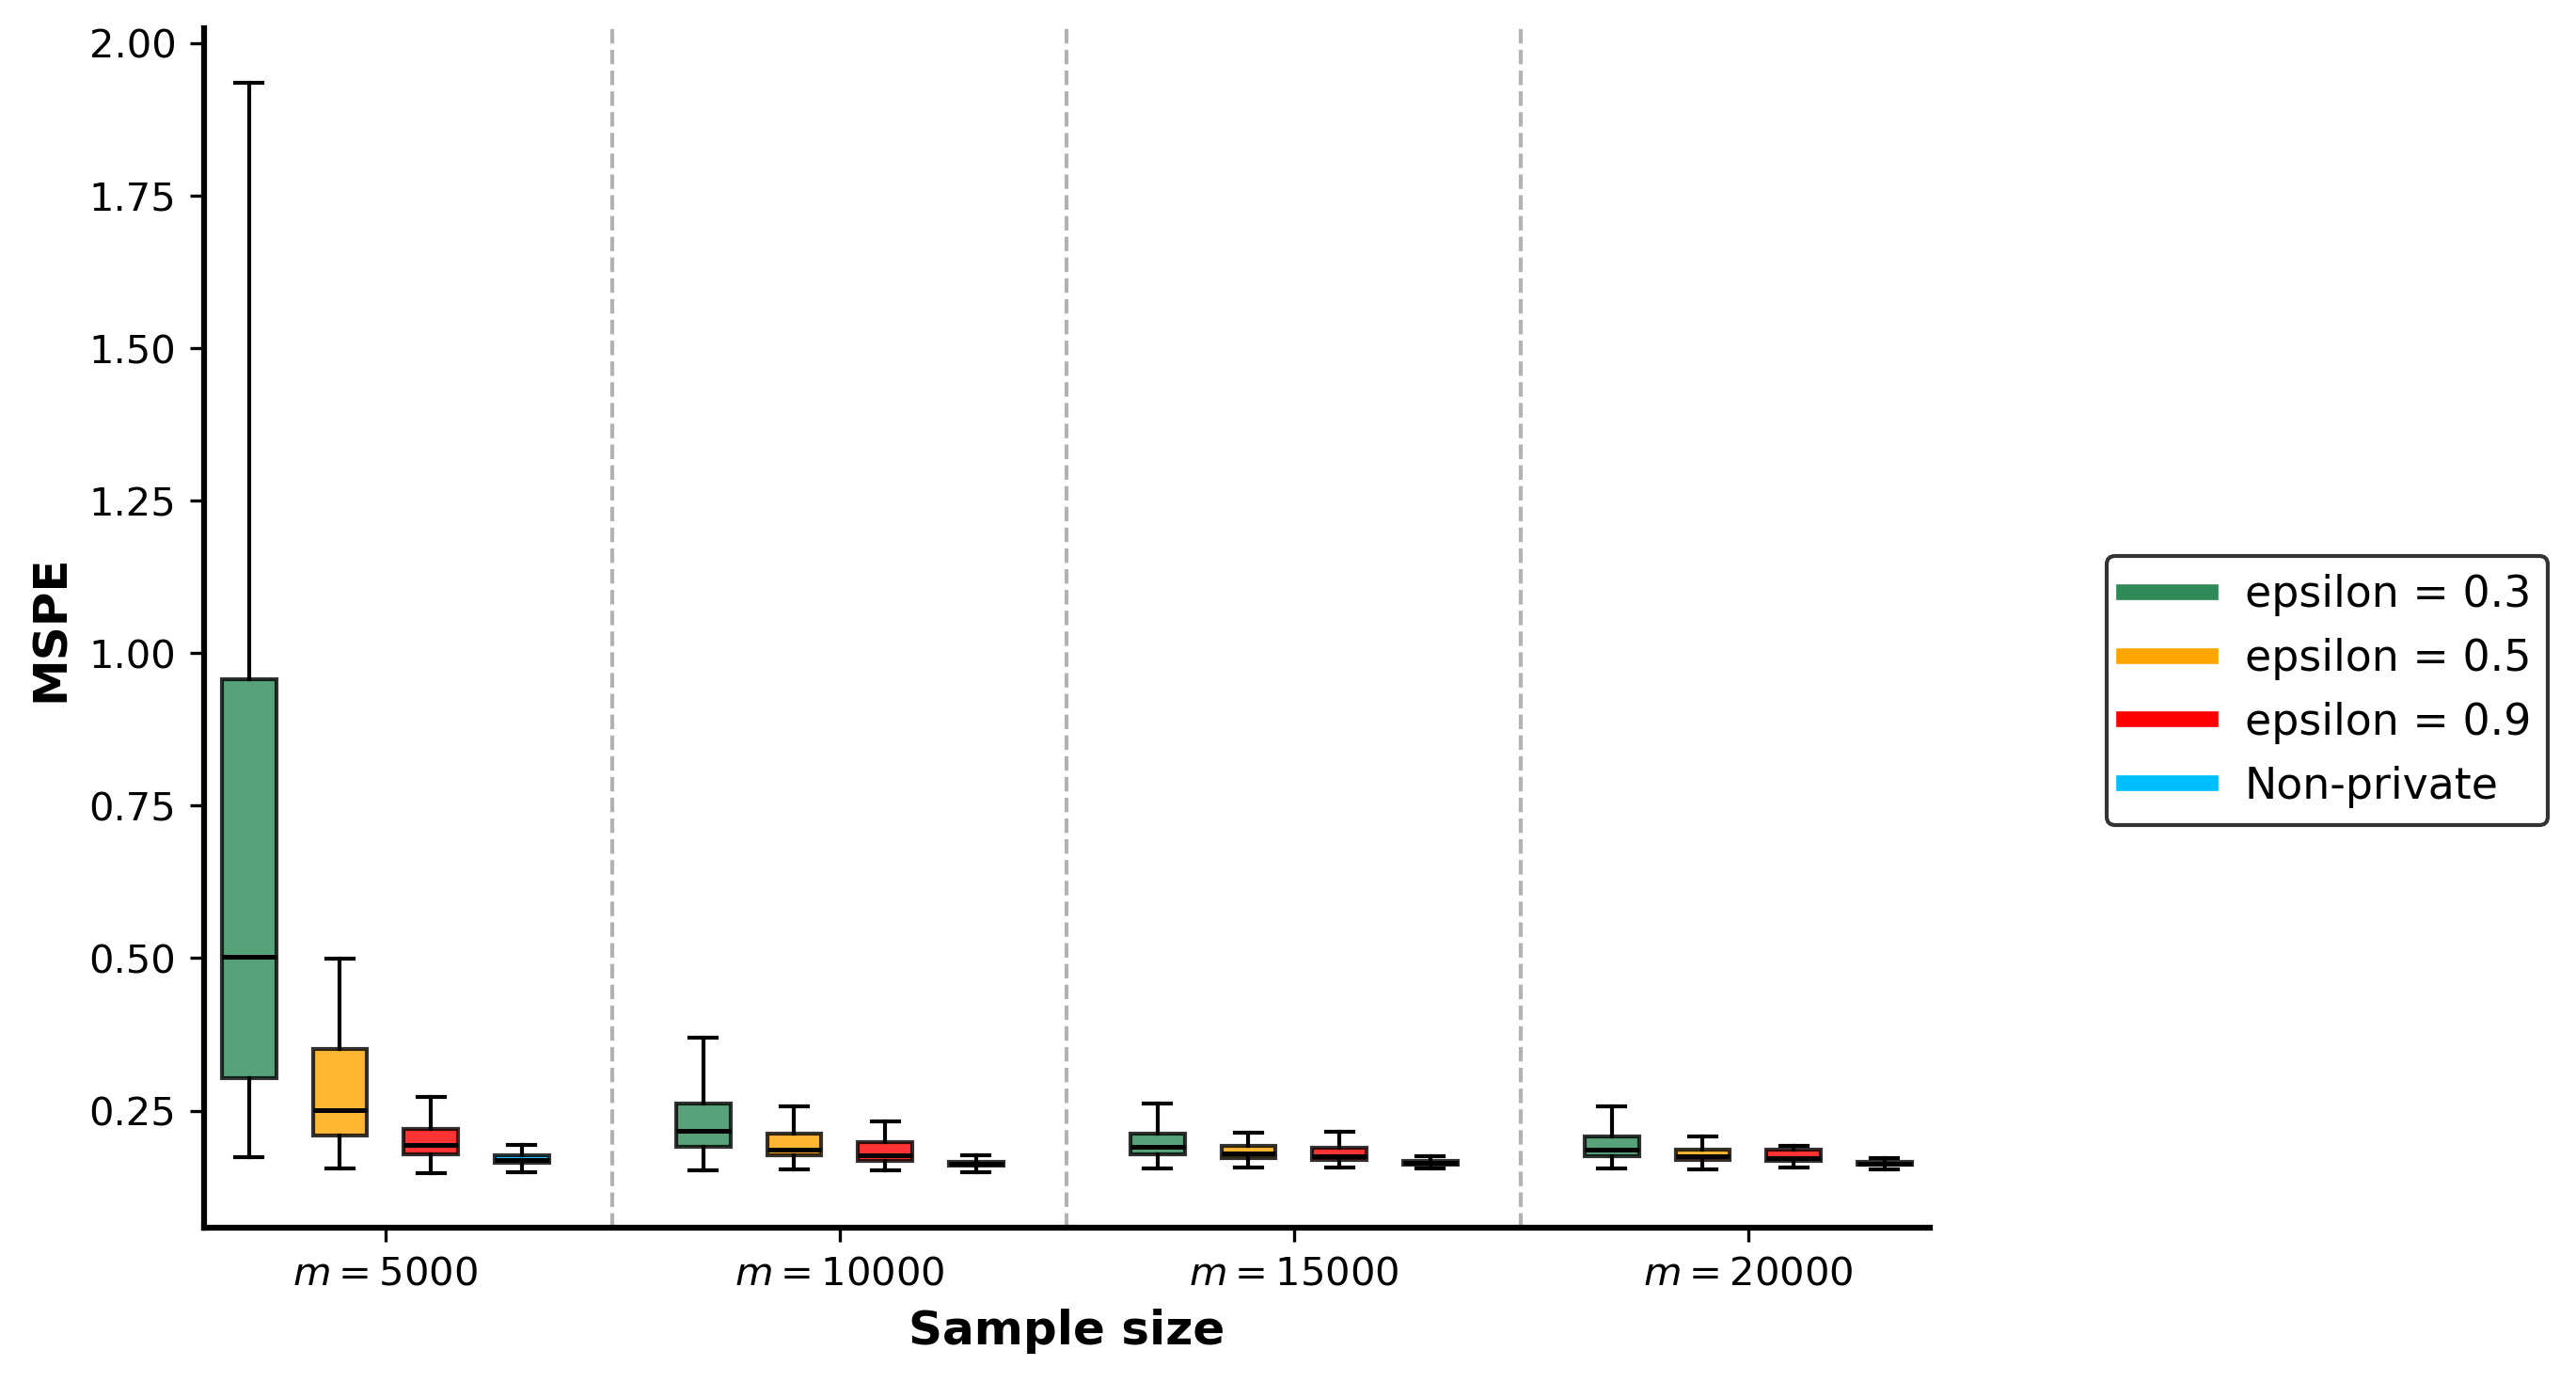

In [6]:
fig, ax = plot_mse_boxplots( sequence, result_mse, result_priv1_mse, result_priv2_mse, result_priv3_mse )
#fig.savefig("RD_low.png", dpi=300, bbox_inches='tight')

### Coefficients report

In [11]:
#Y_house_new = np.array(Y_house.copy()).reshape(-1)  ##log median house
Y_house_new = np.array( (data_house['median_house_value']))/25000 ## meaidan house in $10k
Y_house_RD = Y_house_new.copy()
X_house_copy = np.array(X_house.copy())
n = X_house_copy.shape[0]
p = X_house_copy.shape[1]+1
 
#### Comparison ####
epsilon = .5
delta = 10/(n**1.1)
epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
delta_init = delta/6 
epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
delta_est = 5*delta/6 

result_mse = []
result_priv1_mse = []
result_OLS_mse = [] 


############################################### 
#-------------  Private (proposed)  ----------- 
###############################################  
rgt.seed(2025)

#---- initialization ----
epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
tau_init =   St_DP(Y_house_RD, epsilon = epsilon_tau)   
beta_0DP =  huber_ridge_priv(X_house_copy, Y_house_RD, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 

#---- estimation ---- 
gamma = 0.5*(p + np.log(n))**0.5 # truncation paramerter
T = int(np.ceil(2*np.log(n))) # number of iterations
sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
tau_priv = .04*tau_init * (n * epsilon  /(p+np.log(n)))**0.5   
lr =  0.2 # learning rate 
model = Huber(X_house_copy, Y_house_RD,intercept=True) 
out_priv = model.noisygd(tau=tau_priv, lr= lr, beta0=beta_0DP, B=gamma , sigma_scale=sigma_scale,T=T) 
beta_priv = out_priv['beta']
 
        
############################################### 
#----------------  Non-private  --------------- 
###############################################  
model = Huber(X_house_copy, Y_house_new,intercept=True)
tau0 = np.sqrt(np.mean(Y_house_new**2)-(np.mean(Y_house_new)**2))
tau_np = .2*tau0 * (n/(p+np.log(n)))**0.5  
out  = model.gd(tau=tau_np,  lr=0.5 , beta0=np.array([]), T=T) 
beta_np = out['beta']

from numpy.linalg import inv
X_house_copy_new = np.hstack([np.ones((X_house_copy.shape[0], 1)), X_house_copy])  # add intercept
XtX = np.dot(X_house_copy_new.T, X_house_copy_new)
Xty = np.dot(X_house_copy_new.T, Y_house_new)
beta_OLS = np.dot(inv(XtX), Xty)

data_all = np.array([beta_np,beta_priv,beta_OLS   ]) 

methods = ['non private', 'DP Huber' , 'OLS'  ]

# 构造 DataFrame
df = pd.DataFrame(data_all, index=methods, columns=[f'V{i+1}' for i in range(len(data_all[0]))]).round(3)


print(df)

                V1     V2     V3     V4     V5     V6
non private  8.274  3.283  0.990 -1.078  1.494 -0.068
DP Huber     7.785  3.227  0.791 -0.598  0.625  0.389
OLS          8.274  3.493  0.927 -1.787  3.278 -1.217


## High-Dimensional Real Dataset

In this section, we analyze a high-dimensional real-world dataset: **Communities and Crime**. This dataset contains information about various features of communities and their corresponding crime rates.

- **Dataset Overview**:
  - The dataset includes socio-economic and crime data from U.S. communities.  There are 125 features with 18 potential target variables (e.g., various crime rates). 
  - The target variable in our analysis is **ViolentCrimesPerPop**(total number of violent crimes per 100,000 population).

- **Download Address**:
  The dataset can be downloaded from the following link: [Communities and Crime Dataset](https://archive.ics.uci.edu/dataset/211/communities+and+crime+unnormalized) 


### Data Preprocessing for Communities and Crime Dataset

In this step, we process the dataset by selecting **ViolentCrimesPerPop** as the response variable. We handle multicollinearity by removing the following variables, which are linearly correlated:

- `pctUrban`: Percentage of urban population.
- `OwnOccQrange`: Difference between the upper and lower quartiles of home ownership.
- `RentQrange`: Difference between high and low rent quartiles.

After removing these correlated variables, we delete columns with missing data and remove rows where the response variable is missing, leaving 1994 rows and 99 columns for further analysis.

In [12]:
### data ###
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'realdata/highdim/Data.txt')
data_org = pd.read_csv(file_path, delimiter=',', header=None)
colnames_comm = [
    "communityname", "state", "countyCode", "communityCode", "fold", "population", "householdsize",
    "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29",
    "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
    "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap",
    "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov",
    "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy",
    "PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce",
    "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumKidsBornNeverMar",
    "PctKidsBornNeverMar", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10",
    "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly",
    "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous",
    "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone",
    "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "OwnOccQrange", "RentLowQ",
    "RentMedian", "RentHighQ", "RentQrange", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc",
    "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop",
    "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
    "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian",
    "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
    "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy",
    "LemasPctOfficDrugUn", "PolicBudgPerPop", "murders", "murdPerPop", "rapes", "rapesPerPop",
    "robberies", "robbbPerPop", "assaults", "assaultPerPop", "burglaries", "burglPerPop", "larcenies",
    "larcPerPop", "autoTheft", "autoTheftPerPop", "arsons", "arsonsPerPop", "ViolentCrimesPerPop",
    "nonViolPerPop"
]
data_org.columns = colnames_comm
data_org_new = data_org[[  "fold", "population", "householdsize",
"racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29",
"agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
"pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap",
"blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov",
"PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy",
"PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce",
"MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
"PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumKidsBornNeverMar",
"PctKidsBornNeverMar", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10",
"PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly",
"PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous",
"PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
"PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone",
"PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "OwnOccQrange", "RentLowQ",
"RentMedian", "RentHighQ", "RentQrange", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc",
"MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
"PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop",
"LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
"PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian",
"PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
"PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy",
"LemasPctOfficDrugUn", "PolicBudgPerPop",  "ViolentCrimesPerPop" ]]
#sum_ab = data_org_new['RentHighQ']-data_org_new['RentLowQ']- data_org_new['RentQrange'] ## all 0
multicollinearity = ['pctUrban','OwnOccQrange','RentQrange']
# pctUrban = 100*numbUrban / population
# OwnOccQrange = OwnOccHiQuart - OwnOccLowQuart
# RentQrange = RentHighQ - RentLowQ
missing_col = data_org_new.columns[data_org_new.apply(lambda col: col.astype(str).str.contains('\\?').any())]
missing_variable_name = ['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop']
## with missing values
 
columns_to_drop = multicollinearity + missing_variable_name
 
data_COMM = data_org_new.drop(columns=columns_to_drop)
data_COMM = data_COMM[data_COMM['ViolentCrimesPerPop'] != '?'] # Remove rows where the response variable is missing.
data_COMM = data_COMM.reset_index(drop=True)

Y_data_COMM = data_COMM['ViolentCrimesPerPop']
X_data_COMM = data_COMM.drop(columns='ViolentCrimesPerPop')

### Data Preprocessing: Standardization and Removal of Constant Variables

In this step:

1. **Standardization of the Response Variable**: The response variable **ViolentCrimesPerPop** is standardized using **StandardScaler**, which scales the variable to have zero mean and unit variance.

2. **Standardization of Covariates**: All covariates are also standardized using **StandardScaler** to ensure consistency across variables with different units of measurement.

3. **Removal of Intercept Term**: The intercept term is removed to facilitate comparison with the **sparse DP LS**.


In [13]:
from sklearn.preprocessing import StandardScaler
Y_data_COMM_new = Y_data_COMM.values.reshape(-1, 1) 
scaler = StandardScaler()
Y_COMM = scaler.fit_transform(Y_data_COMM_new) 
Y_COMM = pd.Series(Y_COMM.flatten())

scaler_x1 = StandardScaler()
X_COMM = pd.DataFrame(scaler_x1.fit_transform(X_data_COMM), columns=X_data_COMM.columns)
X_COMM = X_COMM.iloc[:,1:] 

### Comparison of sparse DP Huber and sparse DP LS Methods

We compare the prediction errors of the **sparse DP Huber**(`noisygd_highdim`) and **sparse DP LS**(`noisygd_ls`) methods. The results from **sparse Huber**(`gd_highdim`,without noise) serve as the **benchmark** for reference, allowing us to evaluate how the introduction of noise and privacy constraints impacts the performance of the other methods.


In [14]:
n = 1994 
p = X_COMM.shape[1] + 1   
epsilon = 0.9    
s = 5
sequence = np.arange(500,1901,100)
result_Huber = []
result_Huber_noise = [] 

MASTER_SEED = 2025
rgt.seed(MASTER_SEED)
import random
random.seed(MASTER_SEED)

for index in range(len(sequence)):
    rgt.seed(MASTER_SEED+index+1)
    numm = sequence[index]
    print(numm)
    
    random_rows1 = np.random.choice(n, numm, replace=False)
    Y_COMM_sample = Y_COMM.iloc[random_rows1]
    Y_COMM_sample = Y_COMM_sample.reset_index(drop=True)
    X_COMM_sample = X_COMM.iloc[random_rows1]
    X_COMM_sample = X_COMM_sample.reset_index(drop=True)
      
    M=300 
    HD_Huber = np.zeros(M)
    HD_Huber_noise = np.zeros(M)
    for rep in list(range(M)):
        rgt.seed(MASTER_SEED+rep+1)
        #print(rep)
        # Split the data into training and test sets (80%-20%)
        n_train = int(0.8 * numm)
        train_idx = np.random.choice(numm, size=n_train, replace=False)
        test_idx = np.setdiff1d(np.arange(numm), train_idx)  # Get the remaining 20% as test set
        
        delta = 10/(n_train**1.1)

        X_sample_np = X_COMM_sample.to_numpy()
        Y_sample_np = pd.to_numeric(Y_COMM_sample).to_numpy()

        X_train = X_sample_np[train_idx]
        Y_train = Y_sample_np[train_idx]
        X_test = X_sample_np[test_idx]
        Y_test = Y_sample_np[test_idx]

        #privacy budget allocation  
        eps_s = epsilon/3
        eps_init = epsilon/3
        eps_main = epsilon/3  
        delta_init = delta/2
        delta_main = delta/2  

        ############################################### 
        #-------------  Private (proposed)  ----------- 
        ############################################### 

        #----------- index selection -----------
        xi = np.sqrt(np.log(n_train)+np.log(p))  
        U = X_train * Y_train[:, None]
        absU = np.abs(U)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = xi / absU
            ratio[absU == 0.0] = 1.0   # 按理论：u_ij = 0 时，不做截断，权重 1
        weights = np.minimum(ratio, 1.0)
        #weights = np.where(absU > 0.0, np.minimum(xi / absU, 1.0), 1.0)
        U_tilde = U * weights
        g = np.abs(U_tilde.mean(axis=0)) 
        # Global replace-one sensitivity for each score: Δ = 2C / n 
        Delta = 2.0 * xi / n_train 
        dx_peel_1 = dp_top_s_laplace_peeling(g, s-1, eps_s, Delta) 

        #----------- initialization -----------
        support_org = np.asarray(list(dx_peel_1), dtype=int) 
        X_low = X_train[:,support_org]
        epsilon_tau =  eps_init/4  # privacy budget for DP standard deviation estimation: 1/4
        epsilon_ridge =  3*eps_init/4 # privacy budget for DP huber+ridge estimation: 3/4
        tau_init =   St_DP(Y_train, epsilon = epsilon_tau)   
        beta_0DP =  huber_ridge_priv(X_low, Y_train, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 
        beta0DP = np.zeros(p)
        support_selected = np.insert(support_org + 1, 0, 0).astype(int) 
        beta0DP[support_selected] = beta_0DP  

        #----------- estimation -----------
        tau_priv = .04* tau_init * (n_train*epsilon/(s*np.log(p)+np.log(n_train)))**0.5 # robustification parameter for  DP    
        lr_priv =  0.01  
        B_priv = 0.5*(np.log(p) + np.log(n_train))**0.5
        T_priv = int(np.ceil(2*np.log(n_train))) # number of iterations
        if T_priv*np.log(T_priv/delta_main) < 2.5*np.log(2/delta_main)*np.log((2*T_priv)/delta_main):
            epsilon_scale_priv = eps_main/T_priv
            delta_scale_priv = delta_main/T_priv
        else: 
            epsilon_scale_priv = eps_main/np.sqrt(2.5*T_priv*np.log(2/delta_main))
            delta_scale_priv = delta_main/ (2*T_priv)
        model_est = Huber(X_train , Y_train ,intercept=True)
        out_priv = model_est.noisygd_highdim( s=s, lr=lr_priv, T=T_priv,  tau=tau_priv , beta0=beta0DP,  B_high=B_priv,  epsilon_scale =epsilon_scale_priv,  delta_scale=delta_scale_priv )  
        private_Huber_beta = out_priv['beta'] 
         

        ############################################### 
        #----------------  Non-private  --------------- 
        # ###############################################  
        tau0 = np.sqrt(np.mean(Y_train**2)-(np.mean(Y_train)**2))
        tau_np_high = .1 *tau0  * (n_train/(s*np.log(p)+np.log(n_train)))**0.5 # robustification parameter for noiseless Gaussian DP 
        lr_np =  0.2  
        T_np = int(np.ceil(2*np.log(n_train))) # number of iterations 
        model_est = Huber(X_train , Y_train,intercept=True)
        out_np = model_est.gd_highdim(s=s, lr=lr_np, T=T_np,  tau=tau_np_high, beta0=np.array([]),  standardize= False)  
        Huber_beta = out_np['beta']




        # MSE calculations
        X_test_new = np.concatenate([np.ones((len(X_test), 1)), X_test], axis=1)
        Huber_pre = X_test_new @ Huber_beta
        Noise_Huber_pre = X_test_new @ private_Huber_beta 
        HD_Huber[rep] = np.mean((Huber_pre - Y_test) ** 2)
        HD_Huber_noise[rep] = np.mean((Noise_Huber_pre - Y_test) ** 2) 

    # Average MSE for this sample size
    result_Huber.append(np.mean(HD_Huber))
    result_Huber_noise.append(np.mean(HD_Huber_noise)) 

500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


### Plots for High-Dimensional realdata Results

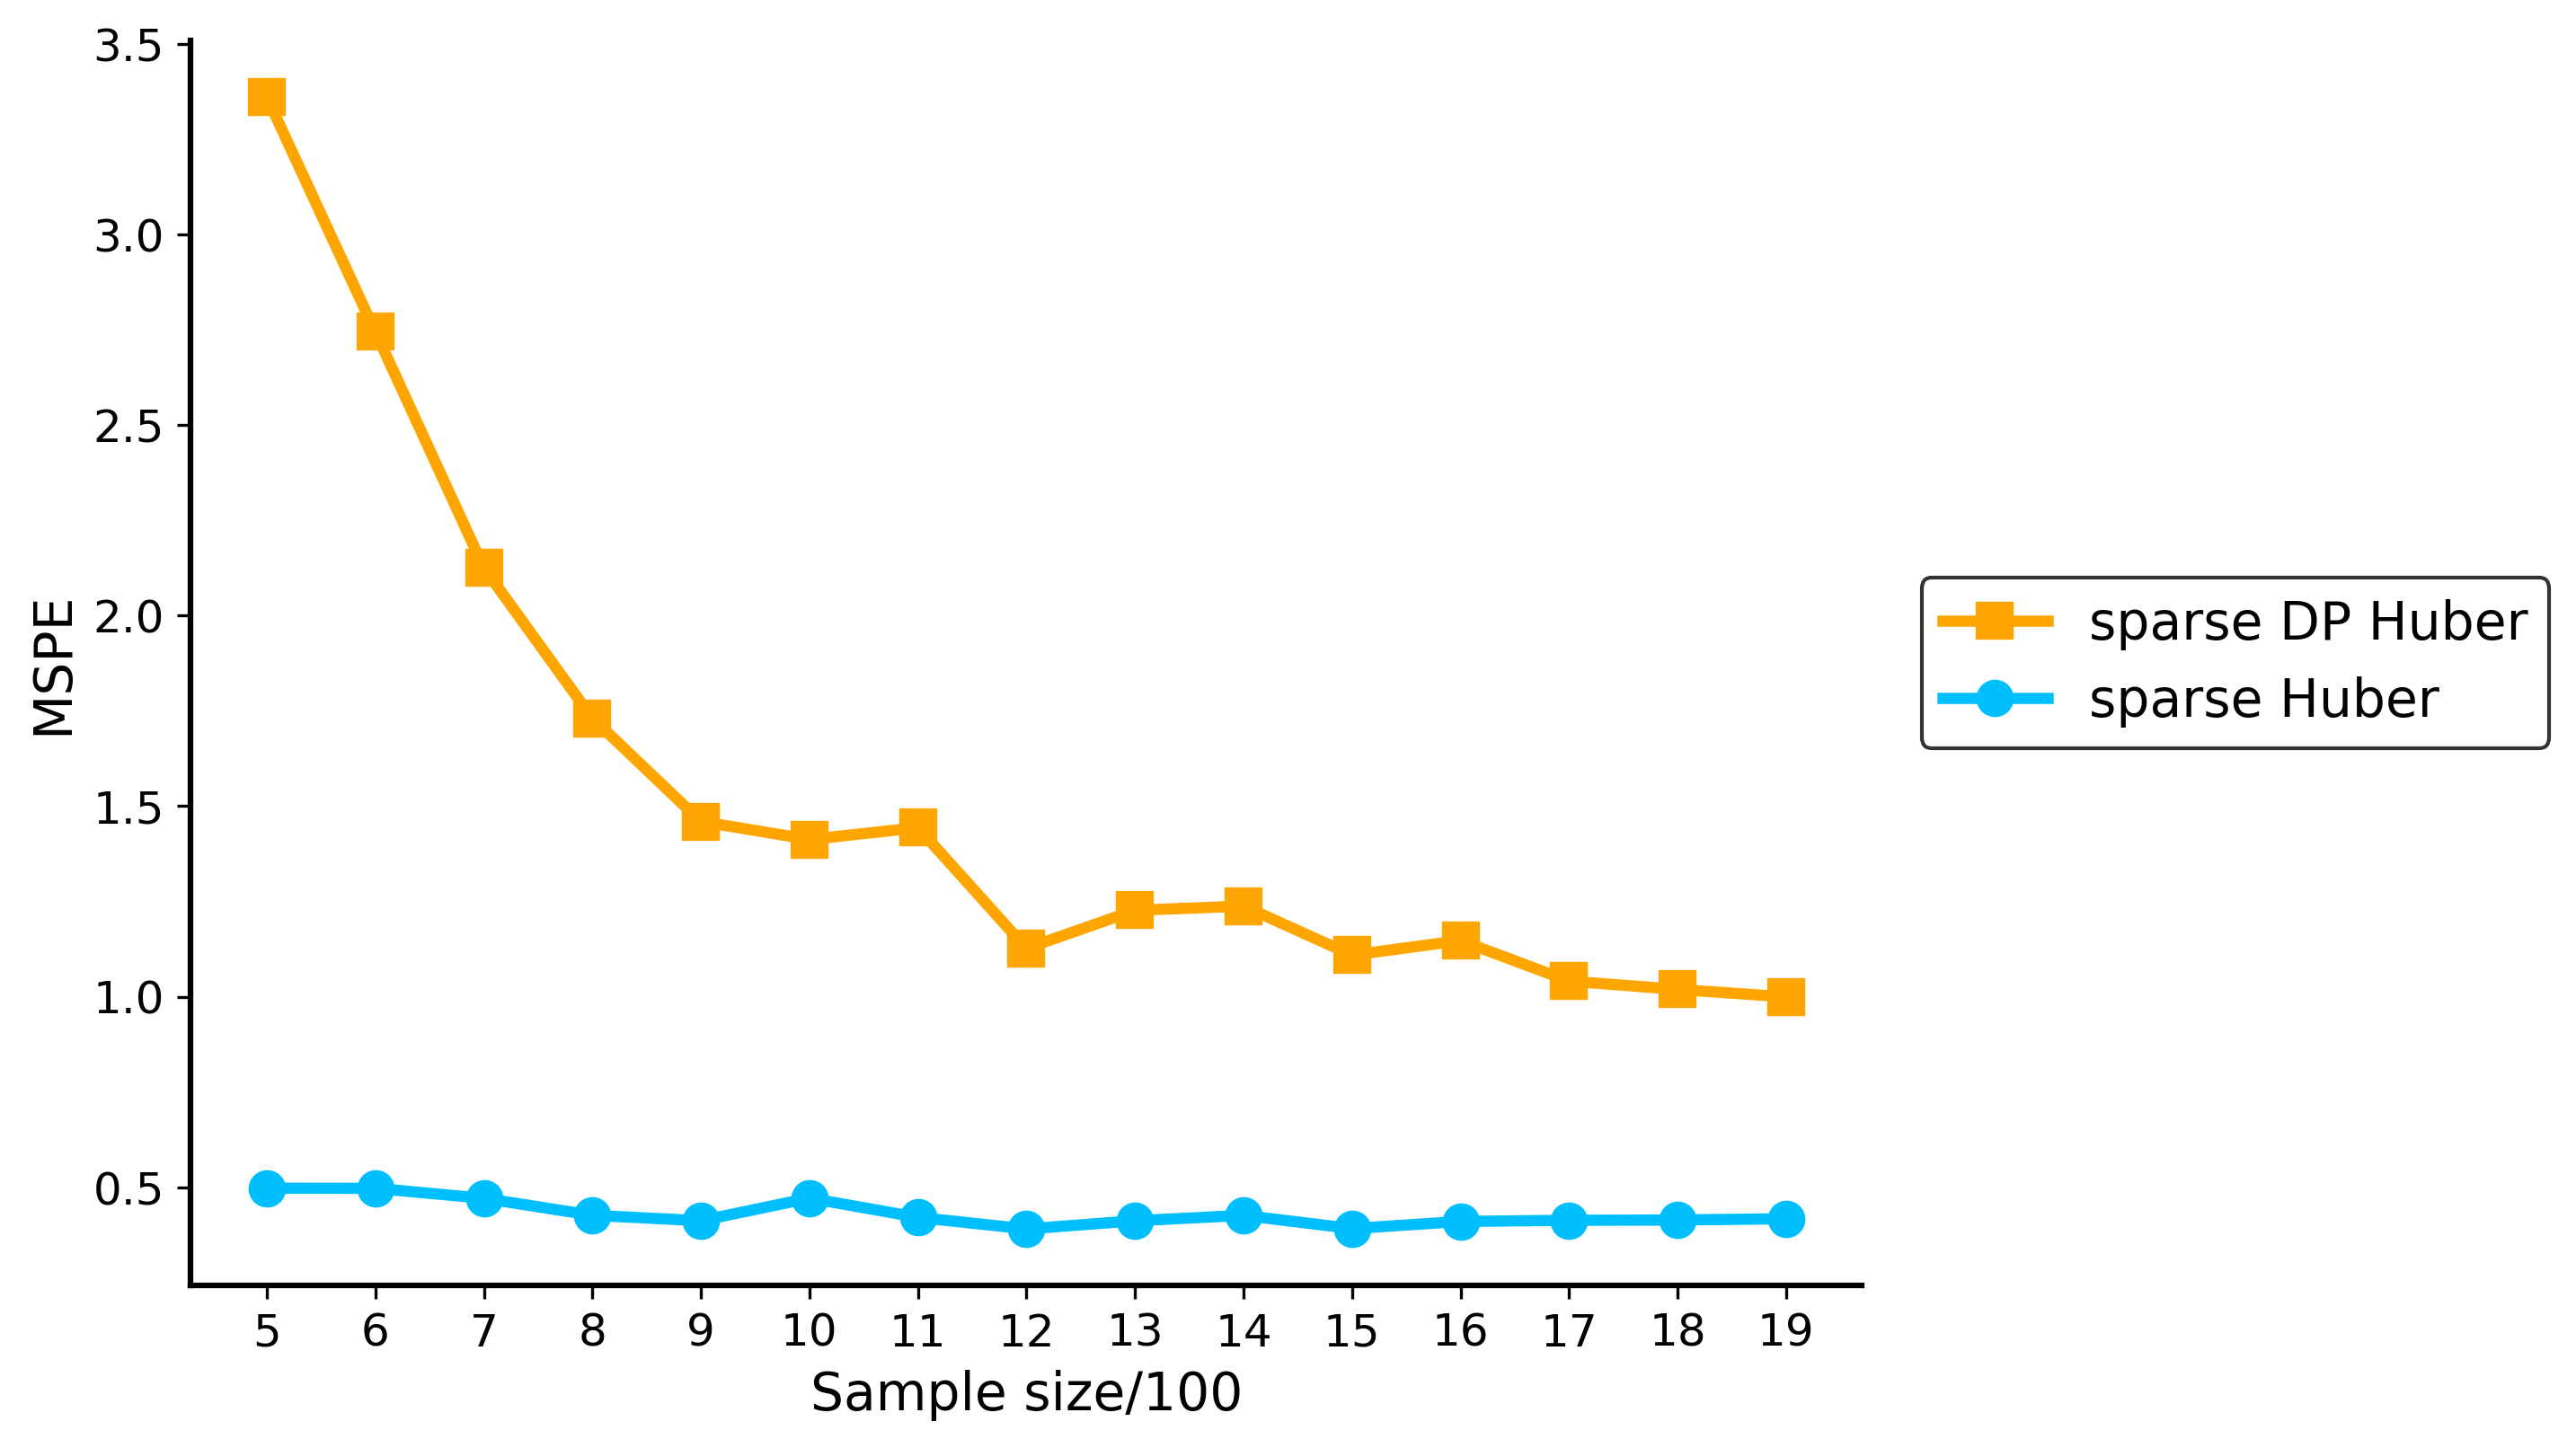

In [15]:
sequence_new = sequence/100
plt.figure(figsize=(8,6), dpi=300)  


plt.plot(sequence_new,np.array(((result_Huber_noise))),
           label='sparse DP Huber', marker='s', color='orange', linewidth=3,markersize=8, markeredgewidth=2)


plt.plot(sequence_new,np.array((result_Huber)),
            label='sparse Huber', marker='o', color='deepskyblue', linewidth=3,markersize=8, markeredgewidth=2)

plt.xlabel('Sample size/100', fontsize=14)
plt.ylabel('MSPE', fontsize=14) 
plt.xticks(np.arange(min(sequence_new), max(sequence_new)+1, 1), fontsize=12)  
plt.yticks(fontsize=12)
legend = plt.legend(
    frameon=True,
    fontsize=14,
    loc='center left',        
    bbox_to_anchor=(1.02, 0.5)   
)
frame = legend.get_frame()
frame.set_edgecolor('black')   
frame.set_linewidth(1)        
frame.set_facecolor('white')
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.5) 
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')  

#plt.savefig("RD_high.png", dpi=300, bbox_inches='tight')
